In [28]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def hard_tresholding(x: torch.Tensor, treshold: torch.Tensor) -> torch.Tensor:
    return torch.where(torch.abs(x) > treshold, x, torch.zeros_like(x))


def soft_tresholding(x: torch.Tensor, treshold: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.relu(x - treshold)


def differentiable_hard_tresholding(x: torch.Tensor, threshold: torch.Tensor, temperature=1) -> torch.Tensor:
    x_offset = x - threshold
    return torch.nn.functional.relu(x_offset + threshold*torch.tanh(x_offset/temperature))


def sym_differentiable_hard_tresholding(x: torch.Tensor, treshold: torch.Tensor, temperature=1) -> torch.Tensor:
    return differentiable_hard_tresholding(x, treshold, temperature) - differentiable_hard_tresholding(-x, treshold, temperature)



In [46]:
inp = 8*torch.randn(2000)
thresh_gt = 2.4
out_gt = hard_tresholding(inp, thresh_gt)
learnable_threshold = torch.nn.Parameter(1.*torch.ones(1))
optimizer = torch.optim.SGD([learnable_threshold], lr=0.01)
losses = []
learnt_tresh = []
total_steps = 4000
for step in range(total_steps):
    temperature = 1e-3+ np.linspace(5, 0., num=total_steps, endpoint=True)[step]
    optimizer.zero_grad()
    out_pred = sym_differentiable_hard_tresholding(inp, learnable_threshold, temperature=temperature)
    error = torch.mean((out_pred - out_gt)**2)
    error.backward()
    optimizer.step()
    losses.append(error.item())
    learnt_tresh.append(learnable_threshold.detach().item())
print(temperature)


0.001


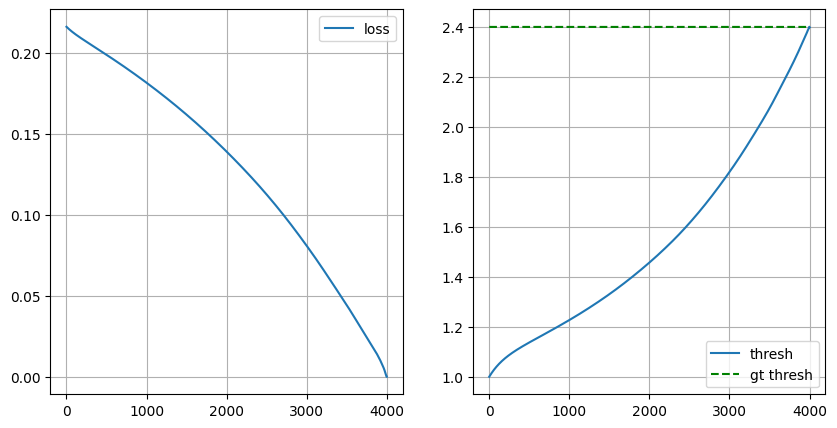

In [47]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label="loss")
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(learnt_tresh, label="thresh")
plt.plot([thresh_gt]*len(losses), "g--", label="gt thresh")
plt.grid()
plt.legend()
plt.show()

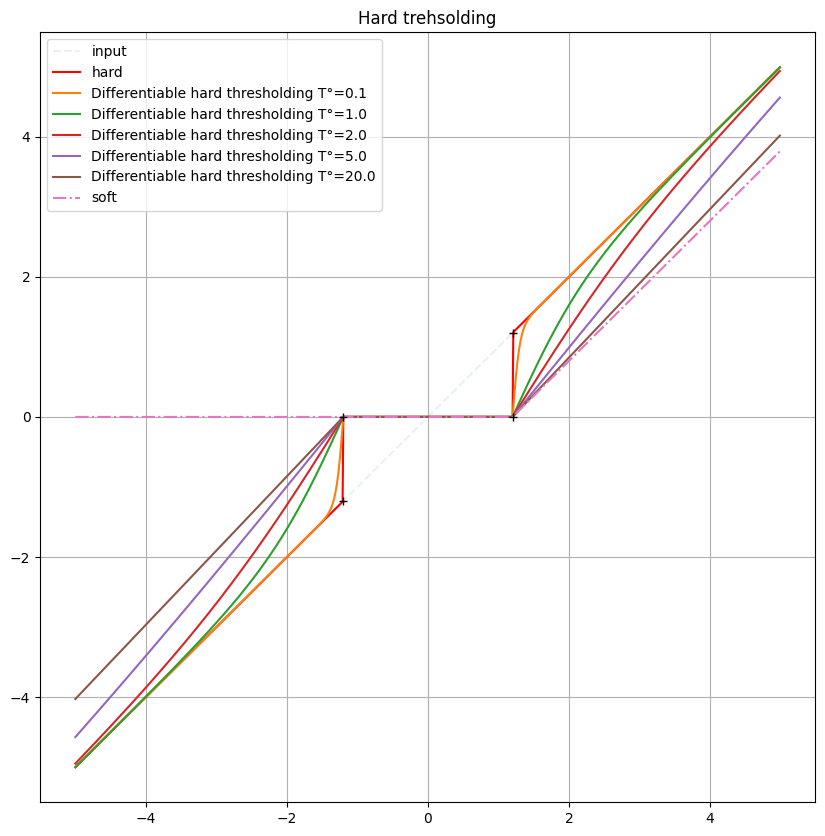

In [50]:

inp = torch.arange(-5, 5, 0.01)
thresh = 1.2
threshold = torch.nn.Parameter(thresh*torch.ones(1))
out_hard = hard_tresholding(inp, threshold)
out_soft = soft_tresholding(inp, threshold)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(inp, inp.detach().numpy(), "--", alpha=0.1, label="input")
plt.plot(inp, out_hard.detach().numpy(), "r-", label="Hard thresholding")
for temperature in [0.1, 1., 2., 5., 20.]:
    out_dhard = sym_differentiable_hard_tresholding(inp, threshold, temperature=temperature)
    plt.plot(inp, out_dhard.detach().numpy(), "-", label=f"Differentiable hard thresholding T°={temperature}")
plt.plot(inp, out_soft.detach().numpy(), "-.", label="Soft thresholding")
plt.plot([thresh, thresh], [0, thresh], "k+")
plt.plot([-thresh, -thresh], [0, -thresh], "k+")
plt.title("Hard trehsolding")
plt.legend()
plt.grid()
plt.show()

In [39]:
out_soft.backward(torch.ones_like(out_soft))

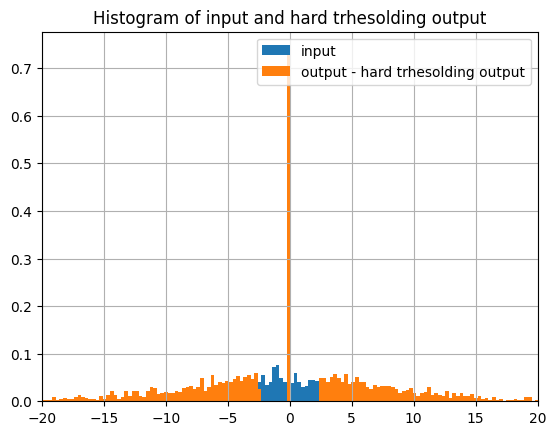

In [56]:
inp = 8*torch.randn(2000)
thresh_gt = 2.4
out_gt = hard_tresholding(inp, thresh_gt)
# plt.plot(inp, "o")
# plt.plot(out_gt, "+")
# plt.show()
plt.figure()
plt.hist(inp.detach().numpy(), bins=200, label="input", density=True)
plt.hist(out_gt.detach().numpy(), bins=200, label="output - hard trhesolding output", density=True)
plt.legend()
plt.xlim(-20, 20)
plt.grid()
plt.title("Histogram of input and hard trhesolding output")
plt.show()